# Entropy Analysis

## Prolog

### Imports

In [22]:
from importlib import reload
from math import log
import numpy as np          # Numeric Python
import scipy.stats as stats # Distribution functions and stuff
from scipy.optimize import minimize
import sqlite3 as sql       # To fetch data
import analysis             # Own analysis tools
reload(analysis);           # force reload of analysis, for it will be changed often

import seaborn as sb        # Plots
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = analysis.a4_dims

import random

import warnings
warnings.filterwarnings('ignore')

### Table Schemes

In [3]:
analysis.print_table_schemes(
    'data/k3-v500-r4.1.db',
    'experiment',
    'algorithm_run',
    'search_run',
    'dist_1',
    'dist_2'
)

TABLE experiment
  NAME                 DATA_TYPE            PRIMARY_KEY
  id                   INTEGER              1
  experiment_name      TEXT                 0

TABLE algorithm_run
  NAME                 DATA_TYPE            PRIMARY_KEY
  id                   INTEGER              1
  experiment_id        INTEGER              0
  solver               TEXT                 0
  formula_fname        TEXT                 0
  max_clause_len       INTEGER              0
  variables            INTEGER              0
  clauses              INTEGER              0
  cb                   REAL                 0
  time                 INTEGER              0
  sat                  BOOL                 0

TABLE search_run
  NAME                 DATA_TYPE            PRIMARY_KEY
  id                   INTEGER              1
  algorithm_run_id     INTEGER              0
  flips                INTEGER              0
  minimal_unsat        INTEGER              0
  last_unsat           INTEGER          

## Analysis

### Entropy Distribution

[(23577, 5.818810644052204), (19628, 5.786619729502453), (23356, 5.760052319435285), (4757, 5.764908318889628), (4074, 5.73243753967382), (2985, 5.441569526886262), (19130, 5.660842384645038), (15280, 5.873324893793586), (4854, 5.515754497586168), (10332, 5.630991367392725), (15434, 5.754104984162732), (8760, 5.798760042846365), (19074, 5.866670094313698), (17743, 5.655468150203317), (12856, 5.786145514167906), (13443, 5.668106726578945), (16439, 5.80253908207713), (17427, 5.714443666615485), (6187, 5.601346096711106), (10515, 5.70297359356231), (16664, 5.743113908186313), (9369, 5.504302590756051), (2322, 5.598897885223572), (13538, 5.7423420947847434), (14995, 5.771105886097523), (17723, 5.512484779465771), (18763, 5.680591727566553), (17831, 5.644762454491046), (6799, 5.6094171658279794), (5453, 5.685264237579728), (21593, 5.853915616045289), (3586, 5.6325443638187895), (7130, 5.760032312853212), (9892, 5.501113415186161), (8118, 5.562634588779346), (20485, 5.818443792734014), (6796

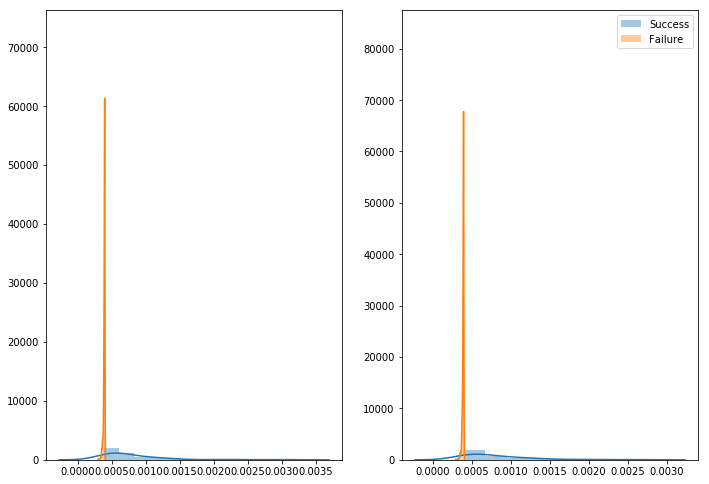

In [33]:
query = """
SELECT search_run.flips, search_run.{}
FROM algorithm_run INNER JOIN search_run ON search_run.algorithm_run_id = algorithm_run.id
WHERE algorithm_run.experiment_id = ? AND search_run.last_unsat {}
"""
   
samples = 2

bins_1 = np.arange(4.0,6.25,0.05) 
bins_2 = np.arange(6.0,10.25,0.05)    
pdf = stats.norm.pdf
bounds = [(0.0001,None),(0.0001,None)]
theta_0 = lambda X: [np.average(X), np.var(X)]

with sql.connect('data/k3-v500-r4.2.db') as conn:
    c = conn.cursor()
    ids, = zip(*c.execute('SELECT id FROM experiment')) # Get experiment indices
    ids = random.sample(ids, samples)                   # Choose three experiments randomly
    
    print(list(c.execute(query.format('h_1', '= 0'),(1,))))
    div = (lambda stuff: stuff[1]/stuff[0])
    #div = (lambda stuff: stuff[1])
    
    XS_sat = [list(map(div,c.execute(query.format('h_1', '= 0'),(exp_id,)))) for exp_id in ids]
    
    YS_sat = [list(map(div,c.execute(query.format('h_2', '= 0'),(exp_id,)))) for exp_id in ids]
    
    XS_unsat = [list(map(div,c.execute(query.format('h_1', '> 0'),(exp_id,)))) for exp_id in ids]
    
    YS_unsat = [list(map(div,c.execute(query.format('h_2', '> 0'),(exp_id,))))  for exp_id in ids]

    print(YS_unsat)

    #figX, axesX = plt.subplots(1,samples)
    #for i,X in enumerate(XS_sat):
    #    sb.distplot(X, label = 'Success', ax = axesX[i], hist=True, bins=bins_1)
        #res = minimize(
        #    fun = lambda args: -analysis.log_likelihood(lambda x: pdf(x, *args), X),
        #    x0  = theta_0(X),
        #    bounds = bounds,
        #)
        #if res.success:
        #    loc, scale = res.x
        #    axesX[i].plot(bins_1, np.vectorize(lambda x: pdf(x, loc, scale))(bins_1))
        #else:
        #    print(loc, scale)
                
        
    #for i,X in enumerate(XS_unsat):
    #    sb.distplot(X, label = 'Failure', ax = axesX[i], hist=True, bins=bins_1)
        #res = minimize(
        #    fun = lambda args: -analysis.log_likelihood(lambda x: pdf(x, *args), X),
        #    x0  = theta_0(X),
        #    bounds = bounds,
        #)
        #if res.success:
        #    loc, scale = res.x
        #    axesX[i].plot(bins_1, np.vectorize(lambda x: pdf(x, loc, scale))(bins_1))
        #else:
        #    print(loc, scale)
    #plt.legend()
        
    figY, axesY = plt.subplots(1,samples)
    for i,Y in enumerate(YS_sat):
        sb.distplot(Y, label = 'Success',ax = axesY[i], hist=True)
        #res = minimize(
        #    fun = lambda args: -analysis.log_likelihood(lambda x: pdf(x, *args), Y),
        #    x0  = theta_0(Y),
        #    bounds = bounds,
        #)
        #if res.success:
        #    loc, scale = res.x
        #    axesY[i].plot(bins_2, np.vectorize(lambda x: pdf(x, loc, scale))(bins_2))
        #else:
        #    print(loc, scale)
            
    for i,Y in enumerate(YS_unsat):
        sb.distplot(Y, label = 'Failure',ax = axesY[i], hist=True)  
        #res = minimize(
        #    fun = lambda args: -analysis.log_likelihood(lambda x: pdf(x, *args), Y),
        #    x0  = theta_0(Y),
        #    bounds = bounds,
        #)
        #if res.success:
        #    loc, scale = res.x
        #    axesY[i].plot(bins_2, np.vectorize(lambda x: pdf(x, loc, scale))(bins_2))
        #else:
        #    print(loc, scale)
    plt.legend()
    

In [8]:
for i,x in enumerate([11,33,44]):
    print(i,x)

0 11
1 33
2 44
